In [5]:
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from execute_remote_scripts import *
%matplotlib widget
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2
import shutil

from Processing_Data.EDA import *
from Processing_Data.create_labels import * # To load the data in dictionaries

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Loading classified shots in dictionaries; time: 6min 27
base_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_test' # Change this depending on purpose
re_autom_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\automatic_RE_numbers.csv'
re_valid_path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Data\validated_RE_numbers.csv'

dataframes, RE_autom, RE_valid, NO_RE_probably, features = load_and_process_data(
    base_path, re_autom_path, re_valid_path, check_nans_infs
)

# Print results
print(f"Loaded {len(dataframes)} shots.")
print(f"Automatic RE shots: {len(RE_autom)}")
print(f"Validated RE shots: {len(RE_valid)}")
print(f"Probably NO RE shots: {len(NO_RE_probably)}")
print(f"Features: {features}")

Replaced 4573 outlier values with capped thresholds.
DataFrame 84162: 832 NaNs found. Replacing NaNs with 0.
Replaced 6299 outlier values with capped thresholds.
Replaced 4266 outlier values with capped thresholds.
Replaced 6627 outlier values with capped thresholds.
DataFrame 86646: 232 NaNs found. Replacing NaNs with 0.
Replaced 6315 outlier values with capped thresholds.
Replaced 7238 outlier values with capped thresholds.
Replaced 10234 outlier values with capped thresholds.
Replaced 7164 outlier values with capped thresholds.
Replaced 6445 outlier values with capped thresholds.
Replaced 4739 outlier values with capped thresholds.
Replaced 6916 outlier values with capped thresholds.
Replaced 7108 outlier values with capped thresholds.
Replaced 4550 outlier values with capped thresholds.
DataFrame 95732: 1408 NaNs found. Replacing NaNs with 0.
Replaced 5148 outlier values with capped thresholds.
DataFrame 95768: 1791 NaNs found. Replacing NaNs with 0.
Replaced 7192 outlier values wi

In [25]:
NO_RE_probably

[84162,
 84869,
 84989,
 86646,
 89183,
 89640,
 89768,
 90579,
 90887,
 93726,
 94641,
 96272,
 99034]

In [26]:
random.seed(42) # So that we always work with the same ones.
random_50_re = random.sample(RE_valid, 7)  # Ensures no duplicates

In [91]:
# #In case we need to recreate the dictionary
# RE_lifetimes = {}

# np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)


In [10]:
dataframes[93936]

,SSXcore,time,IPLA,DAO_EDG7,WMHD,DAI_EDG7,ECE_PF
0,0.003243,53.2662,-14773.960015,1.662650e+13,-1.0,7.235604e+13,2.642404
1,0.003243,53.2672,-14773.960015,1.662650e+13,-1.0,7.235604e+13,2.643238
2,0.003243,53.2682,-14773.960015,1.662650e+13,-1.0,7.235604e+13,2.645185
3,0.003243,53.2692,-14773.960015,1.662650e+13,-1.0,7.235604e+13,2.647874
4,0.003243,53.2702,-14773.960015,1.662650e+13,-1.0,7.235604e+13,2.651535
...,...,...,...,...,...,...,...
5995,0.002136,59.2612,-377.202434,-1.003228e+12,-1.0,1.848650e+13,0.000000
5996,0.001984,59.2622,-1456.609330,-4.901998e+12,-1.0,1.852758e+13,0.000000
5997,0.002213,59.2632,-3136.819484,9.472319e+11,-1.0,4.079275e+13,0.000000
5998,0.002899,59.2642,-2693.304118,-9.393658e+11,-1.0,3.313622e+13,0.000000


In [11]:
# Turn usetex to true if you want to save the figure
plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif"
})

Stop, you are about to redo work!





















































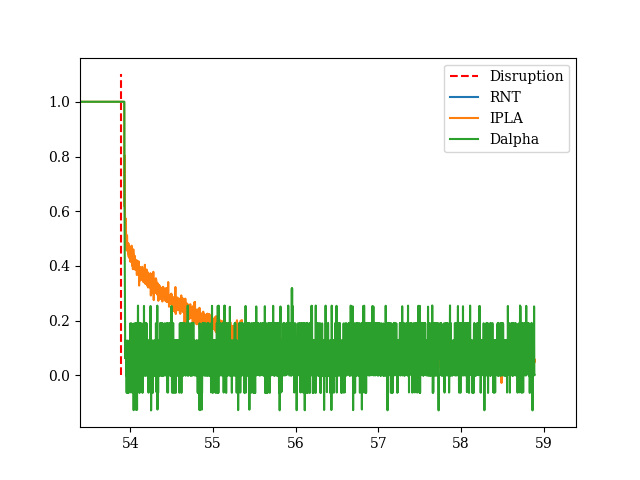

97085


In [29]:
# Shot that is currently processed
k = 3
shot_nr = random_50_re[k]
if str(shot_nr) in list(RE_lifetimes.keys()):
    print('Stop, you are about to redo work!')
    print('\n'*50)

# Load the file and plot it
file_path = os.path.join(base_path, 'JETno' + str(shot_nr)+'.csv')
data = dataframes[shot_nr] # pd.read_csv(file_path)
plt.close()

# Find the first index where time is greater than the starting time + 1
first_index = np.argmax(data['time'] > data['time'][0] + 1)  

# Plot vertical line at this point
plt.vlines(data['time'][first_index], ymin=0, ymax=1.1, color='r', linestyle='dashed', label='Disruption')

#plt.plot(data['time'], data['SSXcore'] /max(data['SSXcore']), label='SSX')
plt.plot(data['time'], data['RNT'] /max(data['RNT']), label='RNT')
plt.plot(data['time'], -data['IPLA'] / max(-data['IPLA']), label='IPLA')
plt.plot(data['time'], -data['DAI_EDG7'] / -max(data['DAI_EDG7']), label='Dalpha')
#plt.plot(data['time'], -data['ECE_PF'] / -max(data['ECE_PF']), label='ECE_PF')

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.5, data['time'][first_index]+5.5)
plt.show()

print(shot_nr)

In [13]:
# Set time that is to be written as end of the beam time
end_beam = 54.043

# Setting shot number again in case I did something weird in between
#shot_nr = random_50_re[k]

# Load the dictionary
RE_lifetimes = np.load(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz")
RE_lifetimes = {key: RE_lifetimes[key] for key in RE_lifetimes.files}
# Set the new value and save
RE_lifetimes[f'{shot_nr}'] = np.array([data['time'][first_index], end_beam])
np.savez(r"C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\RE_lifetime.npz", **RE_lifetimes)

# Plot to verify
plt.close()
plt.vlines(data['time'][first_index], ymin=0, ymax=1.1, color='r', linestyle='dashed', label='Disruption')
plt.vlines(end_beam, ymin=0, ymax=1.1, linestyle='dashed', label='End Beam')
plt.plot(data['time'], -data['IPLA']/max(-data['IPLA']), label='IPLA')
plt.plot(data['time'], -data['RNT'] / -max(data['RNT']), label='RNT')
plt.plot(data['time'], -data['DAI_EDG7'] / -max(data['DAI_EDG7']), label='DAI')
#plt.plot(data['time'], -data['ECE_PF'] / -max(data['ECE_PF']), label='ECE')

# Show the plot
plt.legend()
plt.xlim(data['time'][first_index]-0.02, end_beam+0.05)
plt.title(f'Shot Nr. {shot_nr}')
plt.ylabel('Normalised Observables')
plt.xlabel('Time in s')
#plt.savefig(fr'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Processing_Data\Interesting_Images\RE_Window_{shot_nr}.svg', format='svg')
plt.show()

NameError: name 'data' is not defined

In [166]:
len(RE_lifetimes)

60

## Creating targets from beam durations

In [151]:
save_path_targets = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_targets'
targets = save_re_targets(RE_lifetimes, base_path, save_path_targets)

# Creating train shots targets without runaways
NO_RE_train = np.copy(NO_RE_probably)
random.shuffle(NO_RE_train)
NO_RE_train = NO_RE_train[:int(len(RE_lifetimes))] # Pick as much random ones as we have targets with runaways
targets_no_re = save_no_re_targets(NO_RE_train, base_path, save_path_targets)

In [179]:
# saving them for training
path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\CSV_Files'
destination = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Features'

if not os.path.exists(destination):
    os.mkdir(destination)

for key in RE_lifetimes.keys(): 
    df = dataframes[int(key)]
    df.to_csv(os.path.join(destination, 'JETno' + str(key) + '.csv'))
    
for key in NO_RE_train: 
    df = dataframes[int(key)]
    df.to_csv(os.path.join(destination, 'JETno' + str(key) + '.csv'))


True False


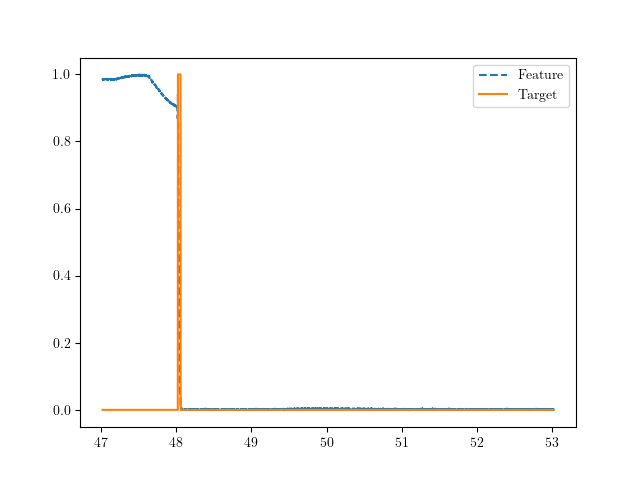

In [ ]:
# Plot random labeled shot for verification
shot_nr = os.listdir(save_path_targets)[random.randint(0, len(os.listdir(save_path_targets)))].split('.')[0].split('no')[1]

# Load the file and plot it
feature_path = os.path.join(base_path, 'JETno' + str(shot_nr)+'.csv')
target_path = os.path.join(save_path_targets, 'JETno' + str(shot_nr)+'.csv')
feature = pd.read_csv(feature_path)
target = pd.read_csv(target_path)

plt.close()
plt.plot(feature['time'], -feature['IPLA'] /max (-feature['IPLA']), '--', label='Feature')
plt.plot(feature['time'], target['target'], label='Target')
plt.legend()
print(int(shot_nr) in RE_valid, int(shot_nr) in NO_RE_probably)